# Custom bluesky plan

**Objective**: 
Build a custom plan for an up-down scan using positioner `m2` and `scaler1` channels `I0` and `diode`.

First, a couple lines to make the graphics and also EPICS Channel Access and work here.

In [1]:
try:
    %load_ext dotenv
    %dotenv env.txt
except Exception:
    print(
        "Did not load file with environment variables."
        "  No problem.  Continuing ..."
    )

Did not load file with environment variables.  No problem.  Continuing ...


Start the instrument package, which provides python objects for the instrument hardware, plans, utility functions, and the `logger` object.

In [2]:
from instrument.collection import *

I Mon-13:15:59 - ############################################################ startup
I Mon-13:15:59 - logging started
I Mon-13:15:59 - logging level = 10
I Mon-13:15:59 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/collection.py
I Mon-13:15:59 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Mon-13:15:59 - #### Bluesky Framework ####
I Mon-13:15:59 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_python.py
I Mon-13:15:59 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_bluesky.py
I Mon-13:16:00 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/initialize.py
I Mon-13:16:00 - using databroker catalog 'training'
I Mon-13:16:00 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/metadata.py
I Mon-13:16:00 - #### Devices ####
I Mon-13:16:00 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/area_detector.py
I Mon-13:16:00 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/calculation_records.py
I Mon-13:16:02 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/ioc_stats.py
I Mon-13:16:02 - /h

## Select scaler channels
The scaler channels are selected by calling its `.select_channels()` method:

In [3]:
scaler1.select_channels(["I0", "diode"])

## Count time
The count time is in the `.preset_time` attribute.  The way to set the scaler with this time is to use ophyd's staging process.  Add `preset_time` to the `.stage_sigs` dictionary with the desired count time as the value.

In [4]:
scaler1.stage_sigs["preset_time"] = 1
scaler1.stage_sigs

OrderedDict([('preset_time', 1)])

# Construct the plan
Create a plan that scans up, then scans down (2 scans total).  Add `temperature` just to get some other interesting data.  We'll add a metadata key (to the `md` dictionary) for the scan direction.

We'll do this in small steps starting with the innermost part.

In [5]:
def up_down_once(lo, hi, num, md={}):
    dets = [scaler1, temperature]
    _md = {}
    _md.update(md)
    _md["direction"] = "up"
    yield from bp.scan(dets, m2, lo, hi, num, md=_md)
    _md["direction"] = "down"
    yield from bp.scan(dets, m2, hi, lo, num, md=_md)

Verify that this code will process through the RunEngine by testing it without running it.  Use the `summarize_plan()` function imported from the `bluesky` package.  This will show the steps of the measurement.

In [6]:
summarize_plan(up_down_once(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================


Next, build a plan that runs this twice.

In [7]:
def up_down_twice(lo, hi, num, md={}):
    yield from up_down_once(lo, hi, num, md=md)
    yield from up_down_once(lo, hi, num, md=md)

In [8]:
summarize_plan(up_down_twice(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

Finish the custom plan by setting the count time.  Give a default of 1.0 s.

In [9]:
def customScan(lo=0, hi=1, num=5, ct=1, md={}):
    scaler1.stage_sigs["preset_time"] = ct
    _md = {}
    _md.update(md)
    _md["count_time"] = ct
    _md["example"] = "customPlan"

    scaler1.select_channels(["I0", "diode"])
    yield from up_down_twice(lo, hi, num, md=_md)
    scaler1.select_channels()  # reset for all named channels
    del scaler1.stage_sigs["preset_time"]  # remove our custom staging

In [10]:
summarize_plan(customScan(md=dict(demo="concise custom plan example")))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

## Run
Run the `customScan()` plan, using the RunEngine object: `RE()`



Transient Scan ID: 234     Time: 2021-07-26 13:16:08
Persistent Unique Scan ID: '0cd5843f-a17a-4423-9d37-5969ba343ea6'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+------------+----------------------+
|   seq_num |       time |         m2 |         I0 |      diode | temperature_readback |
+-----------+------------+------------+------------+------------+----------------------+
|         1 | 13:16:10.3 |    0.00000 |          6 |          4 |             24.57036 |
|         2 | 13:16:12.1 |    0.25000 |          5 |          4 |             24.60016 |
|         3 | 13:16:14.0 |    0.50000 |          5 |          4 |             24.60085 |
|         4 | 13:16:15.9 |    0.75000 |          4 |          5 |             24.58243 |
|         5 | 13:16:17.8 |    1.00000 |          4 |          5 |             24.58243 |
+-----------+------------+------------+------------+------------+----------------------+
generator scan ['0cd5843f'] (scan

('0cd5843f-a17a-4423-9d37-5969ba343ea6',
 '1e5b4179-669b-4e12-905a-b13bb6cb185b',
 '6a6590b5-2673-48c0-bd48-543aa725bfbd',
 '31ba5101-9dc4-4fb5-856a-b1c57d4a3c81')

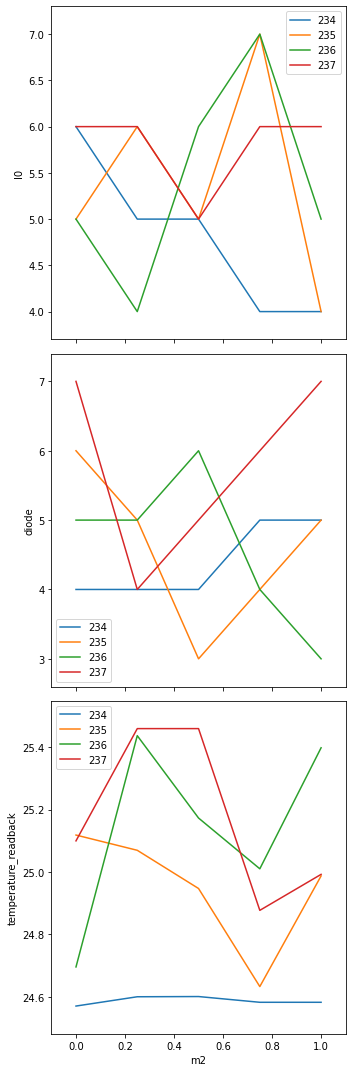

In [11]:
RE(customScan(md=dict(demo="concise custom plan example")))

## Next Steps

Make these additions or improvements to the plans:

1. Use `logger.info()` to provide more feedback from the custom plans (where `logger` is loaded as part of the `instrument` package).
1. Let the caller specify how many *up*-*down* iterations.
1. Let the caller specify the counting time. (hint: `scaler1.stage_sigs["preset_time"] = value` **before** calling `bp.scan()`).
2. Wait between *up* and *down* scans for some time (caller-specified). (hint: `yield from bps.sleep(seconds)`).
3. Use `logger` to report at various places.  (hint: `logger.info("text: %s  value: %g", s1, v2, ...)`)
4. Control the `shutter` (hint: `yield from bps.mv(shutter, "open")` or `close`)
5. Change the temperature before *up* scan and then before *down* scan.  (hint: `yield from bps.mv(temperature, value)`)

### Documentation References

term | brief description | documentation
--- | --- | ---
`bps` | an import: `from bluesky import plan_stubs as bps` | [`bluesky.plan_stubs`](https://blueskyproject.io/bluesky/plans.html#stub-plans)
`stage_sigs` | a dictionary mapping signals to desired values | [Stage and Unstage](https://blueskyproject.io/ophyd/explanations/staging.html?highlight=stage_sigs)